## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

In [1]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


import glob
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
# Global variables

# read in and make a list of calibration images
calibration_dir = './camera_cal/'
output_dir = './output_images/'
test_dir = './test_images/'

# test images
calibration_file = 'calibration1.jpg'
test_file = 'test3.jpg'

objpoints = None
imgpoints = None

mtx = None
dist = None

# Camera Calibration

---

### First compute object and image points from the calibration images

In [3]:
def calibrate_camera():
    images = glob.glob(calibration_dir+'calibration*.jpg')

    # Arrays to store object points and image points from all the images
    global objpoints
    global imgpoints
    objpoints = []
    imgpoints = []
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        # read image
        img = cv2.imread(fname)

        # convert image to gray scale
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        # If corners are found, add object & image points and draw that image
        # There are some images not drawn from this code because we could not find corners
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

# Calibrate camera to find object and image points
calibrate_camera()

### Example of a distortion corrected calibration image

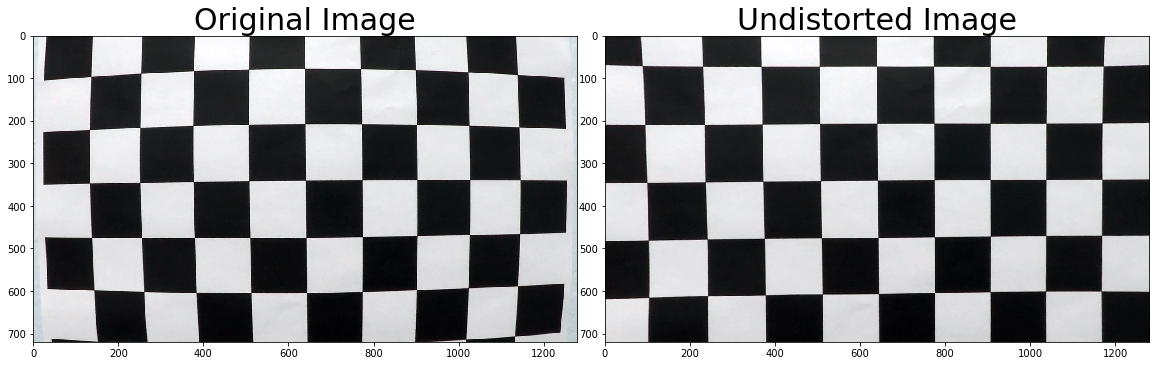

In [4]:
def test_camera_calibration(save_output=True):
    # Read a calibration file
    img = cv2.imread(calibration_dir+calibration_file)

    # Do camera calibration from the object & image points calculated from previous step
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)

    # Undistort image
    dst = cv2.undistort(img, mtx, dist, None, mtx)

    # Save the camera calibration result for later use
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    dist_pickle["rvecs"] = rvecs
    dist_pickle["tvecs"] = tvecs
    dist_pickle["obj_points"] = objpoints
    dist_pickle["img_points"] = imgpoints
    pickle.dump(dist_pickle, open( "calibration.p", "wb" ) )

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    if save_output:
        plt.imsave(fname=output_dir+'1_Original_Calibration.jpg', arr=img)
        plt.imsave(fname=output_dir+'2_Undistorted_Calibration.jpg', arr=dst)
        
# Test undistortion on an image
test_camera_calibration()

## Pipeline

### 1. Example Image for rest of the Pipeline steps

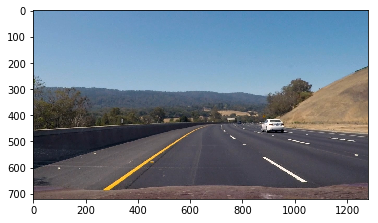

In [5]:
# Choose an image from which to build and demonstrate each step of the pipeline
exampleImg = cv2.imread(test_dir+test_file)
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)

### 2. Undistort Image

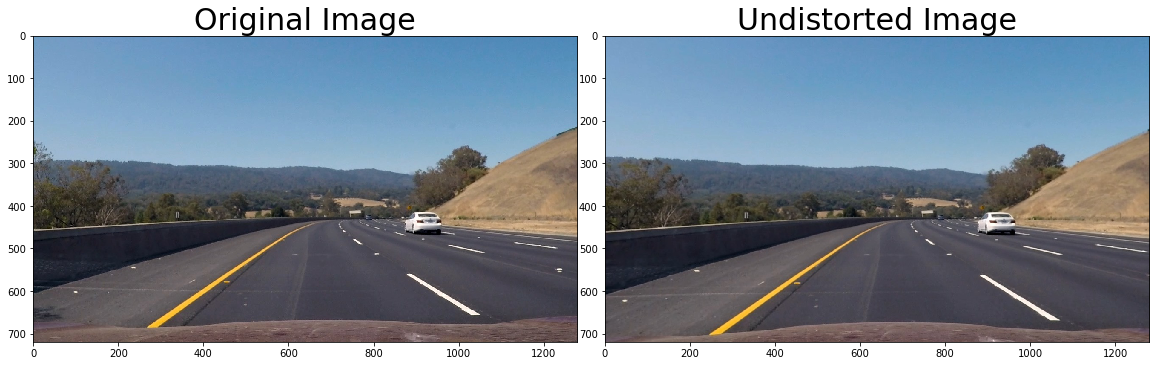

In [6]:
# undistort image using camera calibration matrix from above
def undistort(img):
    global mtx
    global dist
    if mtx is None:
        # calibrate camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1],None,None)
    
    # undistort image
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

def test_undistort(save_outout=True):

    exampleImg_undistort = undistort(exampleImg)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(exampleImg_undistort)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.imsave(fname=output_dir+'3_Original_Road.jpg', arr=exampleImg)
    plt.imsave(fname=output_dir+'4_Road_Transformed.jpg', arr=exampleImg_undistort)

test_undistort()

## Color and Gradient transform

In [7]:
def abs_sobel_thresh(gray, orient='x', min=20, max=200):
    # select x or y
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient == 'x', orient == 'y')
    
    # absolute sobel value
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    
    binary_output = np.uint8(255*abs_sobel/max_value)
    mask = np.zeros_like(binary_output)
    mask[(binary_output >= min) & (binary_output <= max)] = 1
    return mask

def directional_threshold(gray, sobel_kernel=3, thresh=(np.pi/6, np.pi/2)):
    # Calculate gradient x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # absolute value
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    
    # calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    
    # create a mask
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return mask

def threshold_image(img):
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape
    
    # apply x_gradient threshold
    sx_binary = abs_sobel_thresh(gray)
    
    # apply directional mask
    dir_binary = directional_threshold(gray)
    
    # combine the gradient and direction thresholds.
    combined_threshold = ((sx_binary == 1) & (dir_binary == 1))
    
    # Y = R & G for yellow lanes
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)
    
    # S channel is most efficient for detecting yellow and white lanes
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    s_thresh = (100, 255)
    s_condition = (S > s_thresh[0]) & (S <= s_thresh[1])

    # combine all the thresholds
    color_combined[(r_g_condition) & (s_condition | combined_threshold)] = 1
    
    # apply mask in a triangular region from bottom left to bottom rigth and mid_height
    mask = np.zeros_like(color_combined)
    vertices = np.array([[0,h-1], [w/2, int(0.5*h) + 60], [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded

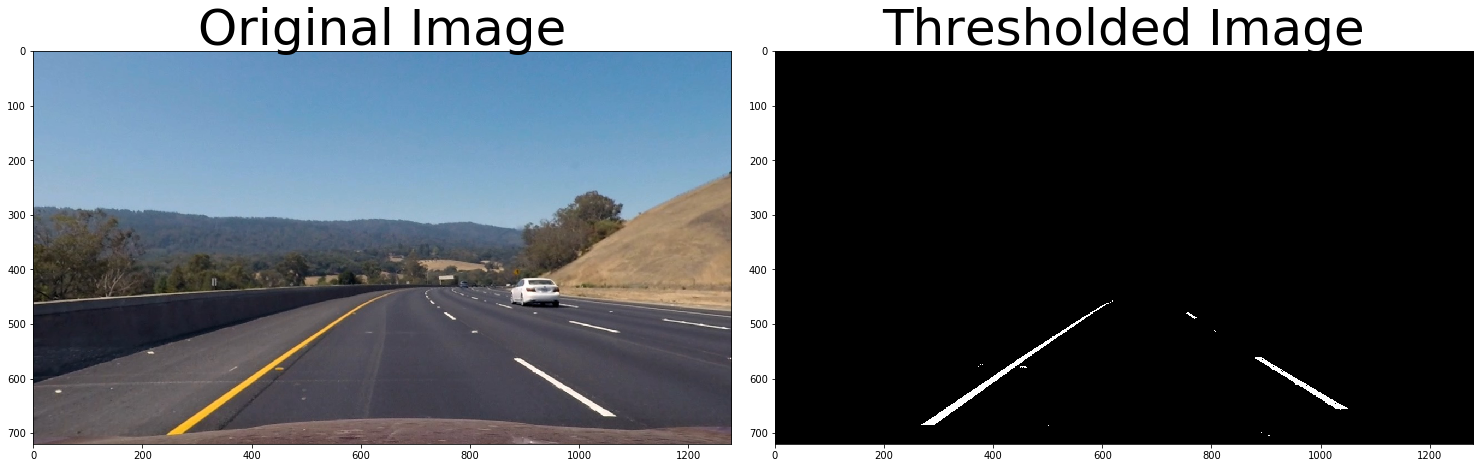

In [8]:
def test_threshold():
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    img = undistort(img)
    plt.imsave(fname=output_dir+'5_Threshold_Image.jpg', arr=thresholded, cmap='gray')

    # Plot the 2 images side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(thresholded, cmap='gray')
    ax2.set_title('Thresholded Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
test_threshold()

## Perspective transform

In [9]:
def unwarp_points(img):
    h,w = img.shape[:2]
    
    # define source and destination points for transform
    # values extracted by trial and test for straight line image
    # such that the unwraped image will result into two parallel lanes
    src = np.float32([(w/2-60,h/2+95),
                      (w/2+60,h/2+95), 
                      (w/2-380,h-50), 
                      (w/2+410,h-50)])
    
    offset = 250
    dst = np.float32([(offset,0),
                      (w-offset,0),
                      (offset,h),
                      (w-offset,h)])
    return (src, dst)

def unwarp(img):
    h,w = img.shape[:2]
    src, dst = unwarp_points(img)
    img_size = (img.shape[1], img.shape[0])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Get the inverse transform
    MInv = cv2.getPerspectiveTransform(dst, src)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, M, MInv, src, dst

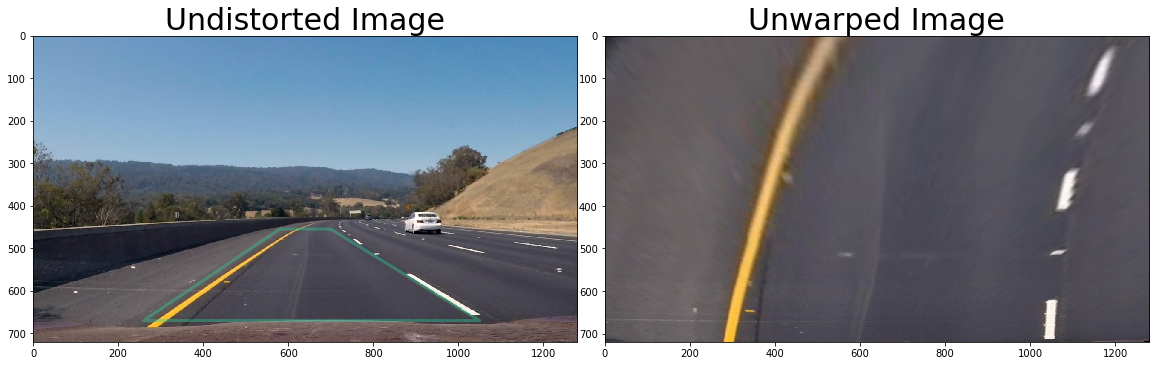

In [10]:
def test_unwrap():
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    h,w = img.shape[:2]
    warped, M, Minv, src, dst = unwarp(img)

    # Visualize unwarp
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
    y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
    ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
    ax1.set_ylim([h,0])
    ax1.set_xlim([0,w])
    ax1.set_title('Undistorted Image', fontsize=30)
    ax2.imshow(warped, cmap='gray')
    ax2.set_title('Unwarped Image', fontsize=30)
    plt.imsave(fname=output_dir+'6_Unwraped_Image.jpg', arr=warped, cmap='gray')
    
test_unwrap()

## Identify Lane Lines

In [11]:
# Takes in warped image
def histogram(warped):    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    
    # First half for left lane and second half for right lane
    mid_x = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:mid_x])
    rightx_base = np.argmax(histogram[mid_x:]) + mid_x
    
    return histogram, leftx_base, rightx_base
    

909 1878


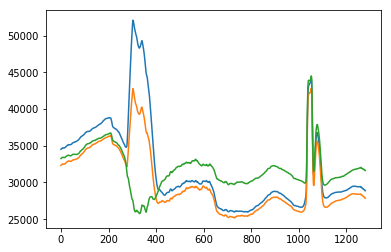

In [12]:
def test_histogram():
    img = mpimg.imread(test_dir+test_file)
    warped, M, Minv, src, dst = unwarp(img)
    hist, leftx_base, rightx_base = histogram(warped)
    
    print(leftx_base, rightx_base)
    plt.plot(hist)

test_histogram()

### Sliding Window Search

In [13]:
class Lines():
    def __init__(self, out_img, left_x_predictions, right_x_predictions, y_points, warped, polyfit_left, polyfit_right, non_zeros_x, non_zeros_y, num_rows):
        self.out_img = out_img
        self.left_x_predictions = left_x_predictions
        self.right_x_predictions = right_x_predictions
        self.y_points = y_points
        self.warped = warped
        self.polyfit_left = polyfit_left
        self.polyfit_right = polyfit_right
        self.non_zeros_x = non_zeros_x
        self.non_zeros_y = non_zeros_y
        self.num_rows = num_rows
        
def sliding_window_search(warped):
    hist, leftx_base, rightx_base = histogram(warped)
    out_img = np.dstack((warped, warped, warped))*255

    non_zeros = warped.nonzero()
    non_zeros_y = non_zeros[0]
    non_zeros_x = non_zeros[1]

    num_windows = 10
    num_rows = warped.shape[0]
    window_height = np.int(num_rows/num_windows)
    window_half_width = 50

    min_pixels = 100

    left_coordinates = []
    right_coordinates = []

    for window in range(num_windows):
        y_max = num_rows - window*window_height
        y_min = num_rows - (window+1)* window_height

        left_x_min = leftx_base - window_half_width
        left_x_max = leftx_base + window_half_width

        cv2.rectangle(out_img, (left_x_min, y_min), (left_x_max, y_max), [0,0,255],2)

        good_left_window_coordinates = ((non_zeros_x >= left_x_min) & (non_zeros_x <= left_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        left_coordinates.append(good_left_window_coordinates)

        if len(good_left_window_coordinates) > min_pixels:
            leftx_base = np.int(np.mean(non_zeros_x[good_left_window_coordinates]))

        right_x_min = rightx_base - window_half_width
        right_x_max = rightx_base + window_half_width

        cv2.rectangle(out_img, (right_x_min, y_min), (right_x_max, y_max), [0,0,255],2)

        good_right_window_coordinates = ((non_zeros_x >= right_x_min) & (non_zeros_x <= right_x_max) & (non_zeros_y >= y_min) & (non_zeros_y <= y_max)).nonzero()[0]
        right_coordinates.append(good_right_window_coordinates)

        if len(good_right_window_coordinates) > min_pixels:
            rightx_base = np.int(np.mean(non_zeros_x[good_right_window_coordinates]))

    left_coordinates = np.concatenate(left_coordinates)
    right_coordinates = np.concatenate(right_coordinates)

    out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
    out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]

    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]

    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]

    polyfit_right = np.polyfit(right_y, right_x, 2)

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]
    
    return Lines(out_img, left_x_predictions, right_x_predictions, y_points, warped, polyfit_left, polyfit_right, non_zeros_x, non_zeros_y, num_rows)

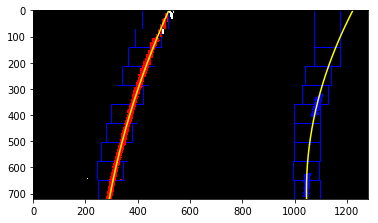

In [14]:
def test_sliding_window_search():
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    img = undistort(img)
    cv2.imwrite('thresholded.jpg',thresholded)

    image_shape = img.shape
    warped, M, Minv, src, dst = unwarp(thresholded)
    lines = sliding_window_search(warped)
    plt.imshow(lines.out_img)
    plt.imsave(fname=output_dir+'7_Fit_Visual.jpg', arr=warped, cmap='gray')
    plt.plot(lines.left_x_predictions, lines.y_points, color='yellow')
    plt.plot(lines.right_x_predictions, lines.y_points, color='yellow')
    plt.xlim(0, warped.shape[1])
    plt.ylim(warped.shape[0],0)
    
test_sliding_window_search()

### Search for lane

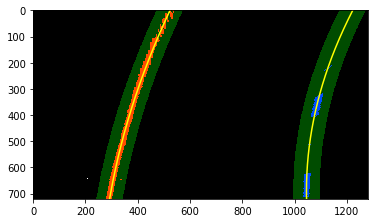

In [15]:
class Lanes():
    def __init__(self, result, left_x_predictions, right_x_predictions, y_points, warped):
        self.result = result
        self.left_x_predictions = left_x_predictions
        self.right_x_predictions = right_x_predictions
        self.y_points = y_points
        self.warped = warped
        
def search_for_lane(lines):
    warped = lines.warped
    polyfit_left = lines.polyfit_left
    polyfit_right = lines.polyfit_right
    non_zeros_x = lines.non_zeros_x
    non_zeros_y = lines.non_zeros_y
    left_x_predictions = lines.left_x_predictions
    right_x_predictions = lines.right_x_predictions
    num_rows = lines.num_rows
    
    margin = 50
    out_img = np.dstack((warped, warped, warped))*255

    left_x_predictions = polyfit_left[0]*non_zeros_y**2 + polyfit_left[1]*non_zeros_y + polyfit_left[2]
    left_coordinates = ((non_zeros_x >= left_x_predictions - margin) & (non_zeros_x <= left_x_predictions + margin)).nonzero()[0]

    right_x_predictions = polyfit_right[0]*non_zeros_y**2 + polyfit_right[1]*non_zeros_y + polyfit_right[2]
    right_coordinates = ((non_zeros_x >= right_x_predictions - margin) & (non_zeros_x <= right_x_predictions + margin)).nonzero()[0]

    out_img[non_zeros_y[left_coordinates], non_zeros_x[left_coordinates]] = [255,0,0]
    out_img[non_zeros_y[right_coordinates], non_zeros_x[right_coordinates]] = [0,0,255]


    left_x = non_zeros_x[left_coordinates]
    left_y = non_zeros_y[left_coordinates]

    polyfit_left = np.polyfit(left_y, left_x, 2)

    right_x = non_zeros_x[right_coordinates]
    right_y = non_zeros_y[right_coordinates]

    polyfit_right = np.polyfit(right_y, right_x, 2)

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_x_predictions = polyfit_left[0]*y_points**2 + polyfit_left[1]*y_points + polyfit_left[2]

    right_x_predictions = polyfit_right[0]*y_points**2 + polyfit_right[1]*y_points + polyfit_right[2]

    window_img = np.zeros_like(out_img)

    left_line_window_1 = np.array(np.transpose(np.vstack([left_x_predictions - margin, y_points])))

    left_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([left_x_predictions + margin, y_points]))))

    left_line_points = np.vstack((left_line_window_1, left_line_window_2))

    cv2.fillPoly(window_img, np.int_([left_line_points]), [0,255, 0])

    right_line_window_1 = np.array(np.transpose(np.vstack([right_x_predictions - margin, y_points])))

    right_line_window_2 = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions + margin, y_points]))))

    right_line_points = np.vstack((right_line_window_1, right_line_window_2))

    cv2.fillPoly(window_img, np.int_([right_line_points]), [0,255, 0])

    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return Lanes(result, left_x_predictions, right_x_predictions, y_points, warped)
    
def test_search_for_lane():
    
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    img = undistort(img)
    
    image_shape = img.shape
    warped, M, Minv, src, dst = unwarp(thresholded)
    lines = sliding_window_search(warped)
    lanes = search_for_lane(lines)
    plt.imshow(lanes.result)
    plt.plot(lanes.left_x_predictions, lanes.y_points, color='yellow')
    plt.plot(lanes.right_x_predictions, lanes.y_points, color='yellow')
    plt.xlim(0, warped.shape[1])
    plt.ylim(warped.shape[0],0)

test_search_for_lane()

### Compute Radius of Curvature and Center offset

In [16]:
def measure_radius_of_curvature(x_values, num_rows):
    ym_per_pix = 30/720
    xm_per_pix = 3.7/700
    y_points = np.linspace(0, num_rows-1, num_rows)
    y_eval = np.max(y_points)

    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(y_points*ym_per_pix, x_values*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    return curverad

# Generate radius of curvature text
def radius_of_curvature_text(left_x_predictions, right_x_predictions, num_rows):    
    left_curve_rad = measure_radius_of_curvature(left_x_predictions, num_rows)
    right_curve_rad = measure_radius_of_curvature(right_x_predictions, num_rows)
    average_curve_rad = (left_curve_rad + right_curve_rad)/2
    curvature_string = "Radius of curvature: %.2f m" % average_curve_rad
    return curvature_string

# Generate center offset text
def center_offset_text(img, left_x_predictions, right_x_predictions):    
    img_size = (img.shape[1], img.shape[0])
    lane_center = (right_x_predictions[719] + left_x_predictions[719])/2
    xm_per_pix = 3.7/700
    center_offset_pixels = abs(img_size[0]/2 - lane_center)
    center_offset_mtrs = xm_per_pix*center_offset_pixels
    offset_string = "Center offset: %.2f m" % center_offset_mtrs
    return offset_string

def test_metrics():
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    img = undistort(img)
    
    image_shape = img.shape
    warped, M, Minv, src, dst = unwarp(thresholded)
    lines = sliding_window_search(warped)
    lanes = search_for_lane(lines)
    
    print(radius_of_curvature_text(lanes.left_x_predictions, lanes.right_x_predictions, lines.num_rows))
    print(center_offset_text(img, lanes.left_x_predictions, lanes.right_x_predictions))
    
test_metrics()

Radius of curvature: 616.58 m
Center offset: 0.15 m


### Inverse Transform of warped image

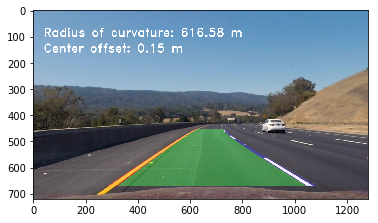

In [17]:
def inverse_transform(lanes, num_rows, Minv, img):
    img_size = (img.shape[1], img.shape[0])
    warped = lanes.warped
    left_x_predictions = lanes.left_x_predictions
    right_x_predictions = lanes.right_x_predictions
    y_points = lanes.y_points
    
    out_img = np.dstack((warped, warped, warped))*255

    y_points = np.linspace(0, num_rows-1, num_rows)

    left_line_window = np.array(np.transpose(np.vstack([left_x_predictions, y_points])))

    right_line_window = np.array(np.flipud(np.transpose(np.vstack([right_x_predictions, y_points]))))

    line_points = np.vstack((left_line_window, right_line_window))

    cv2.fillPoly(out_img, np.int_([line_points]), [0,255,0])
    cv2.polylines(out_img, np.int_([left_line_window]), isClosed=False, color=(255,0,0), thickness=40)
    cv2.polylines(out_img, np.int_([right_line_window]), isClosed=False, color=(0,0,255), thickness=40)

    unwarped = cv2.warpPerspective(out_img, Minv, img_size , flags=cv2.INTER_LINEAR)
    roc = radius_of_curvature_text(lanes.left_x_predictions, lanes.right_x_predictions, num_rows)
    cof = center_offset_text(img, lanes.left_x_predictions, lanes.right_x_predictions)
    result = lanes.result
    result = cv2.addWeighted(img, 1, unwarped, 0.3, 0)
    cv2.putText(result, roc, (40,100), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
    cv2.putText(result, cof, (40,160), cv2.FONT_HERSHEY_DUPLEX, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return result

def test_inverse_transform():
    img = mpimg.imread(test_dir+test_file)
    thresholded = threshold_image(img)
    img = undistort(img)
    
    image_shape = img.shape
    warped, M, Minv, src, dst = unwarp(thresholded)
    lines = sliding_window_search(warped)
    lanes = search_for_lane(lines)
    result = inverse_transform(lanes, lines.num_rows, Minv, img)
    plt.imshow(result)
    plt.imsave(fname=output_dir+'8_Output.jpg', arr=result)
    
test_inverse_transform()

In [18]:
def pipeline(original_img):
    img = original_img.copy()
    img = undistort(img)
    thresholded = threshold_image(img)
    
    image_shape = img.shape
    warped, M, Minv, src, dst = unwarp(thresholded)
    lines = sliding_window_search(warped)
    lanes = search_for_lane(lines)
    result = inverse_transform(lanes, lines.num_rows, Minv, img)
    return result

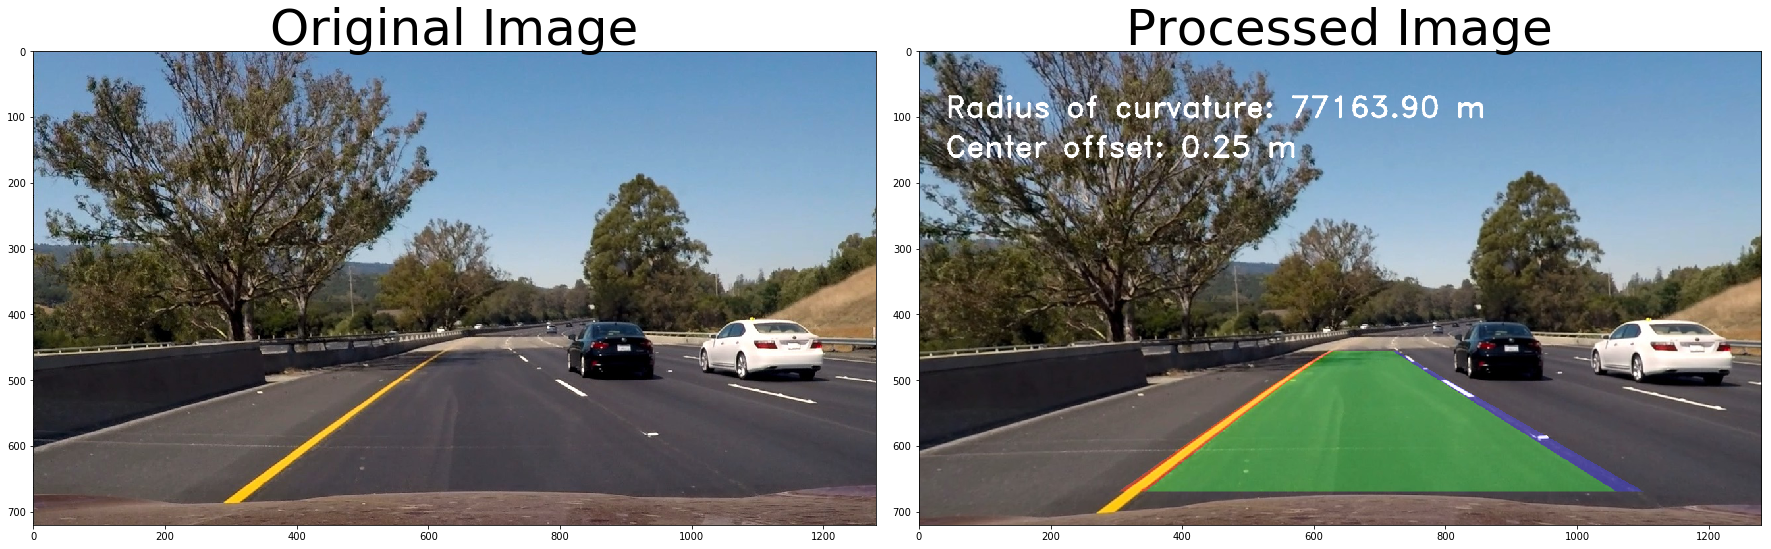

In [19]:
img = mpimg.imread(test_dir+'test6.jpg')

# Apply pipeline
processed = pipeline(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [20]:
from moviepy.editor import VideoFileClip

In [ ]:
output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

In [ ]:
output = 'challenge_video_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

In [ ]:
output = 'harder_challenge_video_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)